**Please Upvote if you like it**

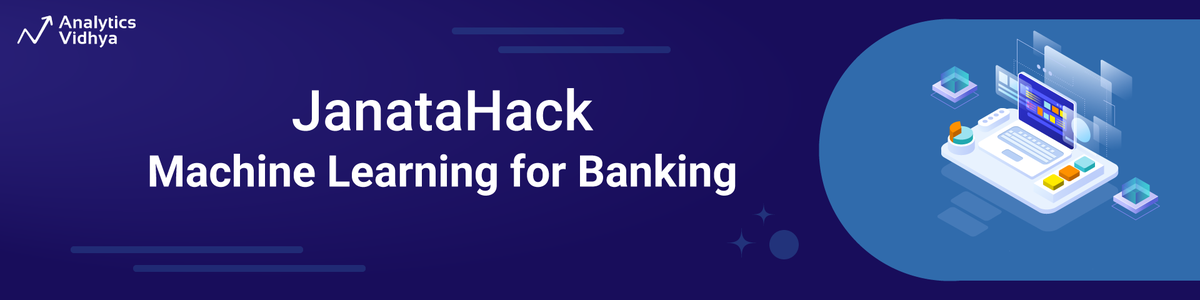

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

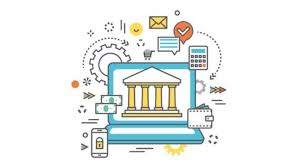

# Problem Statement

> Have you ever wondered how lenders use various factors such as credit score, annual income, the loan amount approved, tenure, debt-to-income ratio etc. and select your interest rates? 
> 
> The process, defined as ‘risk-based pricing’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant. Selection of significant factors will help develop a prediction algorithm which can estimate loan interest rates based on clients’ information. On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate. On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information. Here, your goal is to use a training dataset to predict the loan rate category (1 / 2 / 3) that will be assigned to each loan in our test set.
> 
> You can use any combination of the features in the dataset to make your loan rate category predictions. Some features will be easier to use than others.

# Loading Data

In [ ]:
train = pd.read_csv('/kaggle/input/janatahack-machine-learning-for-banking/train_fNxu4vz.csv')
test = pd.read_csv('/kaggle/input/janatahack-machine-learning-for-banking/test_fjtUOL8.csv')
sample = pd.read_csv('/kaggle/input/janatahack-machine-learning-for-banking/sample_submission_HSqiq1Q.csv')

# Data Description

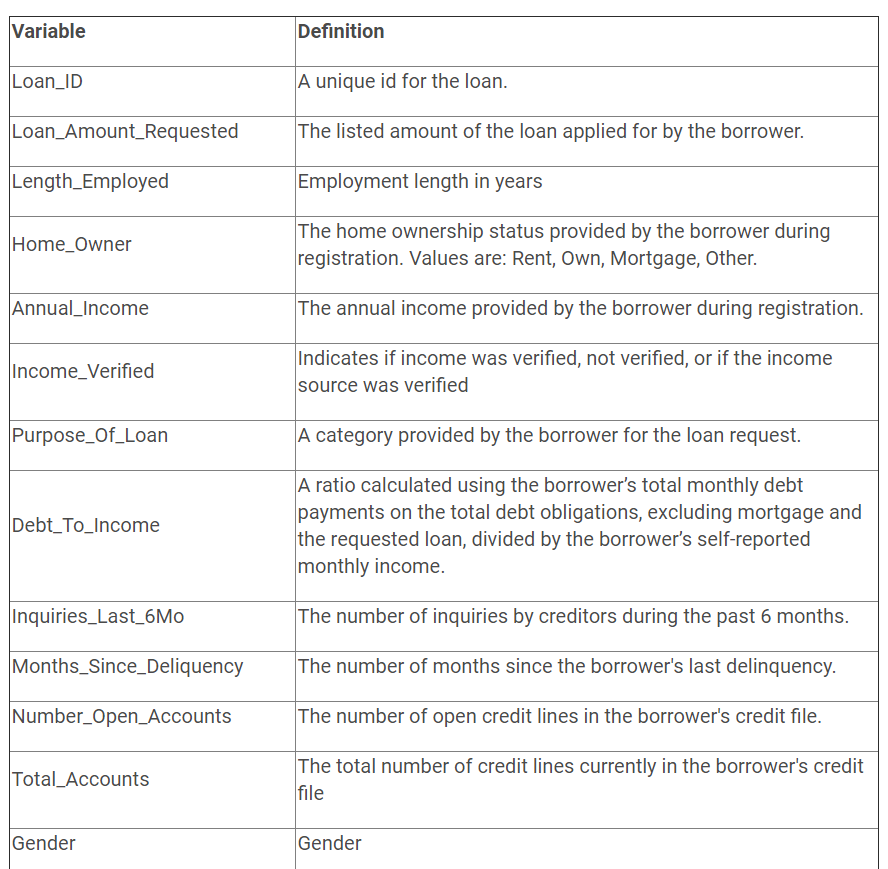

# EDA and Data Vizualization

In [ ]:
print(train.shape)
print(test.shape)
print(sample.shape)

In [ ]:
train.columns

In [ ]:
test.columns

categorical_columns

In [ ]:
categorical_columns = train.select_dtypes(exclude=['int', 'float']).columns
categorical_columns

numerical_columns

In [ ]:
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
numerical_columns

In [ ]:
print(train['Interest_Rate'].value_counts())
sns.countplot(train['Interest_Rate'])

conclusion - It is a balanced Data set

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

Percentage of null values 

In [ ]:
train.isna().sum()/train.shape[0]

In [ ]:
test.isna().sum()/test.shape[0]

In [ ]:
train['Interest_Rate'] = train['Interest_Rate'].astype(int)

Planning to remove Months_Since_Deliquency since it has 50% null value

In [ ]:
print(train['Months_Since_Deliquency'].skew())
print(train['Months_Since_Deliquency'].kurtosis())
sns.distplot(train['Months_Since_Deliquency'])

# kurtosis

Baseline: Kurtosis value of 0

Data that follow a normal distribution perfectly have a kurtosis value of 0. Normally distributed data establishes the baseline for kurtosis. Sample kurtosis that significantly deviates from 0 may indicate that the data are not normally distributed.

Positive kurtosis:

A distribution with a positive kurtosis value indicates that the distribution has heavier tails and a sharper peak than the normal distribution. For example, data that follow a t distribution have a positive kurtosis value.

Negative kurtosis:

A distribution with a negative kurtosis value indicates that the distribution has lighter tails and a flatter peak than the normal distribution. For example, data that follow a beta distribution with first and second shape parameters equal to 2 have a negative kurtosis value.

A negative kurtosis means that your distribution is flatter than a normal curve with the same mean and standard deviation.

So, when is the skewness too much?

The rule of thumb seems to be:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.

If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.

If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.



Learn more about kurtosis at my [blog ](http://www.kaggle.com/learn-forum/154867)

# Concating train and test data into single Dataframe for preprocessing

In [ ]:
df = train.append(test)

In [ ]:
df.shape

In [ ]:

df.plot(kind = 'box',figsize=(20,5))

Annual Income has lot of outliers

# Lets explore each variable and try to fill the missing values

In [ ]:
df.columns

In [ ]:
df['Loan_Amount_Requested'] #Loan applied by the borrower

In [ ]:
df['Loan_Amount_Requested'].isna().sum()

No null values

In [ ]:
df['Loan_Amount_Requested'].dtypes

Loan_Amount_Requested is in object type while it should be numerical value 


In [ ]:
df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(',', '').astype(int)

In [ ]:
print(df['Loan_Amount_Requested'].skew())
print(df['Loan_Amount_Requested'].kurtosis())
sns.distplot(df['Loan_Amount_Requested'])

Postively skewed

Do not follow a normal distribution curve

has less outlier as kurtosis is negative and no tail

Range of values

In [ ]:
print(df['Loan_Amount_Requested'].min())
print(df['Loan_Amount_Requested'].max())

Planning to create a new column on the basis of loan amount

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
df.boxplot(column=['Loan_Amount_Requested'], by='Interest_Rate', ax=ax)

In [ ]:
pd.cut(df['Loan_Amount_Requested'],bins = 3)

In [ ]:
df['Loan_label'] = pd.cut(x=df['Loan_Amount_Requested'], bins= 3, labels=['Low','Medium','High'], right=True)

print(df['Loan_Amount_Requested'])

print(df['Loan_label'].unique())

In [ ]:
dic = {'Low':1,'Medium':2,'High':3}
df['Loan_label'] = df['Loan_label'].map(dic)

In [ ]:
print(df['Loan_Amount_Requested'].corr(df['Interest_Rate']))
print(df['Loan_label'].corr(df['Interest_Rate']))

Pearson's correlation for continuous pair variables, as we know.

spearman's correlation for ordinal pair of variables or at least one of the ordinal variables.

chi-square or Cramer's V test for categorical pair of variables, give you association.

Perform ANOVA and ANCOVA to see the significance of continuous variables across the categories of categorical variables.

# Length_Employed

In [ ]:
df['Length_Employed']

It is in categorical type, we can change into range 

In [ ]:
df['Length_Employed'].value_counts()

Idea is to convert

10+ years to 10 and < 1 years to 0 

In [ ]:
df['Length_Employed'] = df['Length_Employed'].replace('10+ years','10 years')
df['Length_Employed'] = df['Length_Employed'].replace('< 1 year','0 years')

In [ ]:
df.head()

handling missing values and Remove years

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['Length_Employed'])

Replace all null values with mode

In [ ]:
df['Length_Employed'].fillna(df['Length_Employed'].mode()[0],inplace = True)

In [ ]:
df['Length_Employed'].isna().sum()

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['Length_Employed'])

In [ ]:
df[['A','B']] = df['Length_Employed'].str.split(" ",expand = True)

In [ ]:
df['Length_Employed'] = df['A']
del df['A']
del df['B']

In [ ]:
df['Length_Employed'] = df['Length_Employed'].astype(int)

# Home_Owner

In [ ]:
df['Home_Owner'].value_counts()

In [ ]:
df.groupby('Home_Owner')['Interest_Rate'].unique()

In [ ]:
pd.crosstab(train['Home_Owner'],train['Interest_Rate'])

In [ ]:
df['Home_Owner'].isna().sum()/df.shape[0]

15% are null

In [ ]:
sns.countplot(df['Home_Owner'])

In [ ]:
df['Home_Owner'].fillna(df['Home_Owner'].fillna(df['Home_Owner'].mode()[0]),inplace = True)

In [ ]:
sns.countplot(df['Home_Owner'])

# Annual_Income

In [ ]:
print(df['Annual_Income'].skew())
print(df['Annual_Income'].kurtosis())
sns.distplot(df['Annual_Income'])

In [ ]:
df['Annual_Income'].isna().sum()/df['Annual_Income'].shape[0]

In [ ]:
print(df['Annual_Income'].min())
print(df['Annual_Income'].max())

In [ ]:
df['Annual_Income'].fillna(df['Annual_Income'].median(),inplace = True)

In [ ]:
df['Annual_Income']

In [ ]:
num = [200000,500000,100000]

print(type(num[0]))


df['Income_label'] = pd.cut(x=df['Annual_Income'], bins= 3, labels=['Low','Medium','High'], right=True)

print(df['Annual_Income'])

print(df['Income_label'].unique())

In [ ]:
dic = {'Low':1,'Medium':2,'High':3}
df['Income_label'] = df['Income_label'].map(dic)

# Income_Verified

In [ ]:
df['Income_Verified'].value_counts()

In [ ]:
df['Income_Verified'].isna().sum()

In [ ]:
sns.countplot(df['Income_Verified'])

# Purpose_Of_Loan

In [ ]:
df['Purpose_Of_Loan'].isna().sum()

In [ ]:
plt.figure(figsize=(25,8))
sns.countplot(df['Purpose_Of_Loan'])

In [ ]:
df['Debt_To_Income'].isna().sum()

In [ ]:
print(df['Debt_To_Income'].skew())
print(df['Debt_To_Income'].kurtosis())
sns.distplot(df.Debt_To_Income)

# Inquiries_Last_6Mo

In [ ]:
df['Inquiries_Last_6Mo'].isna().sum()

In [ ]:
sns.countplot(df['Inquiries_Last_6Mo'])

# Months_Since_Deliquency

In [ ]:
df['Months_Since_Deliquency']

In [ ]:
deli = []
for i in df['Months_Since_Deliquency']:
    if pd.isnull(i) == True:
        deli.append(0)
    else:
        deli.append(1)
df['Deliquency'] = deli

In [ ]:
df['Deliquency'].value_counts()

In [ ]:
df.drop('Months_Since_Deliquency',axis = 1,inplace = True)

# Number_Open_Accounts

In [ ]:
df['Number_Open_Accounts'].describe()

In [ ]:
df['Number_Open_Accounts'].dtype

In [ ]:
plt.figure(figsize = (20,5))
sns.countplot(df['Number_Open_Accounts'])

In [ ]:
df['Number_Open_Accounts'].isna().sum()

# Total_Accounts

In [ ]:
df['Total_Accounts'].dtype

In [ ]:
plt.figure(figsize = (30,5))
sns.countplot(df['Total_Accounts'])

In [ ]:
df['Total_Accounts'].isna().sum()

In [ ]:
print(df['Total_Accounts'].corr(df['Interest_Rate']))

# gender

In [ ]:
df['Gender'].value_counts()

In [ ]:
df['Gender'].isna().sum()

In [ ]:
sns.countplot(df['Gender'])

In [ ]:
df['Gender'].isna().sum()

Creating new features

In [ ]:
df["Number_Invalid_Acc"] = df["Total_Accounts"] - df["Number_Open_Accounts"]
df["Number_Years_To_Repay_Debt"] = df["Loan_Amount_Requested"]/df["Annual_Income"]


# Completed EDA on all parameters

In [ ]:
df = df[['Loan_ID','Loan_Amount_Requested','Loan_label','Length_Employed','Home_Owner','Annual_Income','Income_label','Income_Verified','Purpose_Of_Loan','Debt_To_Income','Inquiries_Last_6Mo','Number_Open_Accounts','Total_Accounts','Deliquency','Gender','Number_Invalid_Acc','Number_Years_To_Repay_Debt','Interest_Rate']]

In [ ]:
df.head()

In [ ]:
trains = df[df['Interest_Rate'].isna() == False] 
tests = df[df['Interest_Rate'].isna() == True]

In [ ]:
trains['Interest_Rate'] = trains['Interest_Rate'].astype(int)

In [ ]:
trains

# Insights from Data

In [ ]:
trains.groupby('Length_Employed')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

1. Average Loan Amount Requested is maximum for people with 10+ years of experience.
2. Mean Loan_Amount_Requested is minimum for people with <1 year of being employed.

In [ ]:
trains.groupby('Home_Owner')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

Average Loan_Amount_Requested is maximum for people with Home_Owner status as Mortgage.

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=trains['Loan_Amount_Requested'],y=trains['Annual_Income'])

Points at the top of the plot that although the Annual_Income is high, the Loan_Amount_Requested is low.
We can also see a few Annual_Incomes that are more than 1000000.

In [ ]:
trains.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

1. Average loan amount requested is highest for small business followed by debt_consolidation.
2. Average income requested is also high for House loans.

In [ ]:
trains.groupby('Interest_Rate')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

Clearly, there is a distinction between the average loan amount requested for the type of interest rates.
Average Loan Amount seems to be high for Interest Rate category 3 and there is not much between the loan amount for categories 1 and 2.

In [ ]:
trains.groupby('Interest_Rate')['Annual_Income'].agg(['count','min','max','mean','median','std'])

The mean Annual_Income for Interest Rate Category 1 is the highest. And it is almost the same for Interest Rate categories 2 and 3.

# # *Model* Building

In [ ]:
df_new = trains.append(tests)

# Modeling without label encoding

In [ ]:
trains.drop('Loan_ID',axis =1,inplace = True )
tests.drop('Loan_ID',axis =1,inplace = True )

In [ ]:
X_train, Y = trains.drop(["Interest_Rate"], axis=1).values, trains["Interest_Rate"].astype(int).values
X_test = tests.values

X_train.shape, Y.shape, X_test.shape

In [ ]:
trains.head()

In [ ]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1,2,3,5,6,7,12,13])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

In [ ]:
model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y, cat_features=[1,2,3,5,6,7,12,13])
preds1 = model.predict(X_test)

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index=trains.drop(["Interest_Rate"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
sample['Interest_Rate'] = preds1
sample.to_csv('Solution_with_Cat.csv',index=False)

# # Modelling with Label and one hot encoding 

# Label encoding

In [ ]:
cat_columns = ['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender']

In [ ]:
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 

for columns in cat_columns:
    df_new[columns]= le.fit_transform(df_new[columns]) 

In [ ]:
df_new.head()

In [ ]:
col = ['Loan_label','Length_Employed','Home_Owner','Income_label','Income_Verified','Purpose_Of_Loan','Inquiries_Last_6Mo','Deliquency','Gender']

One hot Encoding

In [ ]:
df_new = pd.get_dummies(df_new)

In [ ]:
train_df = df_new[df_new['Interest_Rate'].isna() == False] 
test_df = df_new[df_new['Interest_Rate'].isna() == True]

In [ ]:
train_df

In [ ]:
test_df

# The data is ready for modelling

# It is a classification model

h20 - AutoML

In [ ]:
train_df.drop('Loan_ID',axis = 1,inplace = True)
test_df.drop('Loan_ID',axis = 1,inplace = True)

In [ ]:
train_df['Interest_Rate'] = train_df['Interest_Rate'].astype(int)

In [ ]:
test_df.drop('Interest_Rate',axis = 1,inplace = True)

In [ ]:
import h2o
h2o.init()

train1 = h2o.H2OFrame(train_df)
test1 = h2o.H2OFrame(test_df)
train1.columns
y = 'Interest_Rate'
x = train1.col_names
x.remove(y)
train1['Interest_Rate'] = train1['Interest_Rate'].asfactor()
train1['Interest_Rate'].levels()
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 30, max_runtime_secs=1000, seed = 1)
aml.train(x = x, y = y, training_frame = train1)


In [ ]:
preds = aml.predict(test1)
preds
ans=h2o.as_list(preds) 

sample['Interest_Rate'] = ans['predict']
sample.to_csv('Solution_with_autoML.csv',index=False)

lightGBM, XGBoost, CatBoost, Extra Tree Clasifier can give good results

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#%matplotlib inline 
import os
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
#Model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

Y = train_df['Interest_Rate']
X = train_df.drop('Interest_Rate',axis = 1)
X1 = pd.get_dummies(X)
X_test = test_df

In [ ]:
Y = Y-1

In [ ]:
Y.value_counts()

In [ ]:
evals_result = {}
feature_imp = pd.DataFrame()
features = [feat for feat in X1.columns]
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state =8736)
param = {
    'boost_from_average':'false',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.54,
    'learning_rate': 0.005,
    'max_depth': -1,  
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 16.0,
    'num_leaves': 40,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'multiclass',
    'num_class': 3,
    'verbosity': 1,
    "n_jobs":-1,
    "metric" : "multi_logloss",
}

predictions = np.zeros((len(X1),3))
predictions_test = np.zeros((len(X_test),3))

In [ ]:
X

In [ ]:
X_test

In [ ]:
for fold_, (train_idx,val_idx) in enumerate(folds.split(X1.values,Y.values)):
    print("Fold {}".format(fold_+1))
    d_train = lgb.Dataset(X1.iloc[train_idx][features], label=Y.iloc[train_idx])
    d_val = lgb.Dataset(X1.iloc[val_idx][features],label=Y.iloc[val_idx])
    num_round = 1000000
    clf = lgb.train(param,d_train,num_round,valid_sets=[d_train,d_val],verbose_eval=1000, early_stopping_rounds=5000,evals_result=evals_result)
    oof = clf.predict(X1.iloc[val_idx][features],num_iteration=clf.best_iteration)
    fold_imp = pd.DataFrame()
    fold_imp["Feature"] = features
    fold_imp["importance"] = clf.feature_importance()
    fold_imp["fold"] = fold_ +1
    feat_imp_df = pd.concat([feature_imp,fold_imp], axis=0)
    predictions += clf.predict(X1, num_iteration=clf.best_iteration)
    predictions_test += clf.predict(X_test, num_iteration=clf.best_iteration)
    pred_lab = pd.DataFrame([np.argmax(pr) for pr in predictions])
    oof_lab = pd.DataFrame([np.argmax(pr) for pr in oof])
    acc_score = accuracy_score(Y,pred_lab)
    oof_acc = accuracy_score(Y.iloc[val_idx],oof_lab)
    print("OOF Accuracy {} and Training Accuracy {}".format(oof_acc,acc_score))

In [ ]:
prediction_test_lab = pd.DataFrame([np.argmax(pr) for pr in predictions_test])
prediction_test_lab = prediction_test_lab+1

In [ ]:
prediction_test_lab

In [ ]:
test = list(df[df["Interest_Rate"].isnull()]["Loan_ID"])
sub = pd.DataFrame({"Loan_ID":test,"Interest_Rate":prediction_test_lab[0]})


In [ ]:
train['Interest_Rate'].value_counts()

In [ ]:
sub['Interest_Rate'].value_counts()

# # **try - Different models[[](http://)](http://)

In [ ]:
train_df

In [ ]:
test_df

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import OneHotEncoder, StackingEstimator

In [ ]:
def extra_tree(Xtrain,Ytrain,Xtest):
    extra = ExtraTreesClassifier()
    extra.fit(Xtrain, Ytrain) 
    extra_prediction = extra.predict(Xtest)
    return extra_prediction

In [ ]:
def Xg_boost(Xtrain,Ytrain,Xtest):
    xg = XGBClassifier(loss='exponential', learning_rate=0.05, n_estimators=1000, subsample=1.0, criterion='friedman_mse', 
                                  min_samples_split=2, 
                                  min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  init=None, random_state=None, max_features=None, verbose=1, max_leaf_nodes=None, warm_start=False, 
                                  presort='deprecated', 
                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
    xg.fit(Xtrain, Ytrain) 
    xg_prediction = xg.predict(Xtest)
    return xg_prediction

In [ ]:
def LGBM(Xtrain,Ytrain,Xtest):
    lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=40,
                            max_depth=5, learning_rate=0.05, n_estimators=1000, subsample_for_bin=200, objective='binary', 
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=10,
                            subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0,
                            reg_lambda=0.0, random_state=None, n_jobs=1, silent=True, importance_type='split')
    #lgbm = LGBMClassifier(n_estimators= 500)
    lgbm.fit(X_train, Y_train)
    lgbm_preds = lgbm.predict(X_test)
    return lgbm_preds

In [ ]:
Y_train = train_df['Interest_Rate']
X_train = train_df.drop('Interest_Rate',axis = 1)
X_test = test_df

In [ ]:
pred_xg = Xg_boost(X_train,Y_train,X_test)
pred_et = extra_tree(X_train,Y_train,X_test)
pred_l = LGBM(X_train,Y_train,X_test)

In [ ]:
sample['Interest_Rate'] = pred_xg
print(sample['Interest_Rate'].unique())
sample.to_csv('XG.csv',index = False)

In [ ]:
sample['Interest_Rate'] = pred_et
print(sample['Interest_Rate'].unique())
sample.to_csv('ET.csv',index = False)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
ans = clf.predict(X_test)

In [ ]:
sample['Interest_Rate'] = ans
print(sample['Interest_Rate'].unique())
sample.to_csv('LR.csv',index = False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10).fit(X_train, Y_train)
prediction_of_rf = rf.predict(X_test)
sample['Interest_Rate'] = prediction_of_rf
print(sample['Interest_Rate'].unique())
sample.to_csv('RF.csv',index = False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,Y_train)

# Predicted class
nri = neigh.predict(X_test)

In [ ]:
sample['Interest_Rate'] = nri
print(sample['Interest_Rate'].unique())
sample.to_csv('KNN.csv',index = False)